##Note:
This version patches are saved in memory, then directly feed into Unet


Read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install and use [OpenSlide](https://openslide.org/), the only non-Python dependency. Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. 

### Training data

This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains a few slides and tumor masks prepared in advance with ASAP. This amount of data (or less!) should be sufficient for your project. The goal is to build a thoughtful end-to-end prototype, not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442) discussed in class. If you would like more data than has been provided, you will need to use ASAP to convert it into an appropriate format. 


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 6 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (178 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
! pip install wget

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget

In [2]:
! ls -l --block-size=M

total 1M
drwxr-xr-x 1 root root 1M Apr  4 20:20 sample_data


In [4]:
! mkdir pos pos_label neg neg_label all_patch all_label

mkdir: cannot create directory ‘pos’: File exists
mkdir: cannot create directory ‘pos_label’: File exists
mkdir: cannot create directory ‘neg’: File exists
mkdir: cannot create directory ‘neg_label’: File exists


In [5]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [6]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.1MB/s 


In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


In [0]:
import cv2
from google.colab.patches import cv2_imshow

In [177]:
!ls -l --block-size=M '/gdrive/My Drive/Colab Notebooks/slides'

total 32938M
-r-------- 1 root root   94M Oct 11  2018  tumor_001_mask.tif
-r-------- 1 root root 3114M Oct 11  2018  tumor_001.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_001.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_002_mask.tif
-r-------- 1 root root 1603M Oct 11  2018  tumor_002.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_002.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_005_mask.tif
-r-------- 1 root root 1400M Oct 11  2018  tumor_005.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_005.xml
-r-------- 1 root root   92M Oct 11  2018  tumor_012_mask.tif
-r-------- 1 root root 1552M Oct 11  2018  tumor_012.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_012.xml
-r-------- 1 root root   95M Oct 11  2018  tumor_016_mask.tif
-r-------- 1 root root 1454M Oct 11  2018  tumor_016.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_016.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_019_mask.tif
-r-------- 1 root root 1466M Oct 11  2018  tu

##NOTE:
This block is to test how to save gray scale img to google drive, don't run this part

In [0]:
img=cv2.imread('/gdrive/My Drive/Colab Notebooks/tmp/pos_label/091_label_56_68.png')

In [0]:
img.shape

(256, 256, 3)

In [0]:
img=img[:,:,0]
img*=255

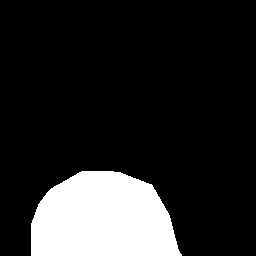

In [0]:
cv2_imshow(img)

In [0]:
cv2.imwrite('tmp.jpg',img)

True

In [0]:
img.shape

(256, 256)

(256, 256)


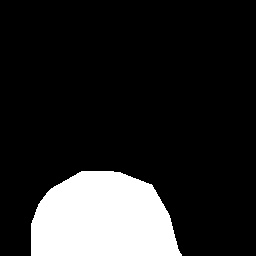

In [0]:
#by using cv2.IMREAD_UNCHANGED, it's reading a img with its original num of channel rather than converting to 3 channels
tmp_img=cv2.imread('tmp.jpg',cv2.IMREAD_UNCHANGED)
print(tmp_img.shape)
cv2_imshow(tmp_img)

In [0]:
upload_to_folder('1uWNSUbHZZCpn-NXjKwf-i9a0C6hlx2WZ', 'tmp.jpg', 'tmp.jpg')

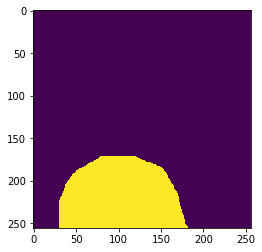

In [0]:
plt.imshow(img)

test complete. procedure: mask[:,:,0], then mask*=255, save to local, then upload to google drive

##Note:
This part is about general visualization of nearly all slides

In [17]:
#get file in folder
files=os.listdir('/gdrive/My Drive/Colab Notebooks/slides')
files[:2]

['tumor_091_mask.tif', 'tumor_091.tif']

In [18]:
#get file name for slide & mask
slide_paths,tumor_mask_paths=[],[]
for item in files:
  if item[-4:] == '.tif':
    if item[-8:-4] == 'mask':
      tumor_mask_paths.append(item)
    else:
      slide_paths.append(item)
print('In total: %d slides.' % len(tumor_mask_paths))
slide_index = [item[6:9] for item in slide_paths]
print('Index of slides:',slide_index)

In total: 21 slides.
Index of slides: ['091', '001', '002', '005', '012', '016', '019', '023', '031', '035', '038', '057', '059', '064', '075', '078', '081', '084', '094', '096', '110', '101']


In [0]:
#get level info about all slides
for i,item in enumerate(slide_paths):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+item
  slide=open_slide(real_path)
  print ("Slide no. %s with %d levels, width: %d, height: %d" % (slide_index[i],
                                                                      len(slide.level_dimensions),
                                                                      slide.level_dimensions[0][0], 
                                                                      slide.level_dimensions[0][1]))

Slide no. 091 with 8 levels, width: 61440, height: 53760
Slide no. 001 with 10 levels, width: 97792, height: 221184
Slide no. 002 with 10 levels, width: 97792, height: 219648
Slide no. 005 with 10 levels, width: 97792, height: 219648
Slide no. 012 with 10 levels, width: 97792, height: 215552
Slide no. 016 with 10 levels, width: 97792, height: 221184
Slide no. 019 with 10 levels, width: 97792, height: 219648
Slide no. 023 with 10 levels, width: 97792, height: 221184
Slide no. 031 with 10 levels, width: 97792, height: 221184
Slide no. 035 with 10 levels, width: 97792, height: 221184
Slide no. 038 with 10 levels, width: 97792, height: 221184
Slide no. 057 with 10 levels, width: 97792, height: 220672
Slide no. 059 with 10 levels, width: 97280, height: 221184
Slide no. 064 with 10 levels, width: 97792, height: 220672
Slide no. 075 with 9 levels, width: 90112, height: 78848
Slide no. 078 with 9 levels, width: 94208, height: 111104
Slide no. 081 with 9 levels, width: 90112, height: 100352
Sli

In [0]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

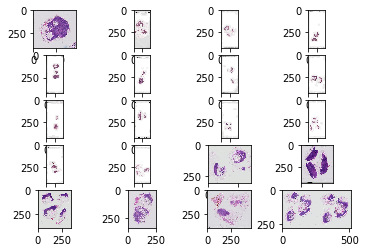

In [0]:
#show imgs at highest level to see general shape
for i in range(20):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[i]
  slide=open_slide(real_path)
  plt.subplot(5,4,i+1)
  level = len(slide.level_dimensions)-1
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  plt.imshow(slide_image)
plt.show()

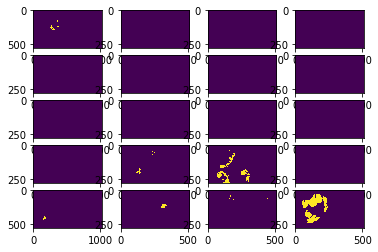

In [0]:
#show masks at highest level to see general shape
for i in range(20):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+tumor_mask_paths[i]
  mask=open_slide(real_path)
  plt.subplot(5,4,i+1)
  level = len(mask.level_dimensions)-1
  mask_image = read_slide(mask, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  mask_image = mask_image[:,:,1]
  plt.imshow(mask_image)
plt.show()

(2240, 4096, 3)


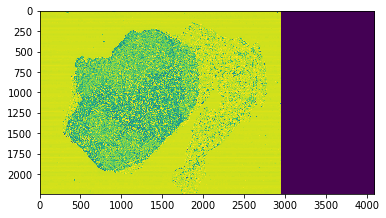

In [0]:
#experiment code block for displaying some img quickly
real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[20]
mask=open_slide(real_path)
level = 5#len(mask.level_dimensions)-1
mask_image = read_slide(mask, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
print(mask_image.shape)
mask_image = mask_image[:,:,2]
plt.imshow(mask_image)
plt.show()

##Note:
This part is about displaying a patch from slides to determine proper level for the project

In [0]:
slide_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[0]
tumor_mask_path = '/gdrive/My Drive/Colab Notebooks/slides/'+tumor_mask_paths[0]

In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)-1):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /gdrive/My Drive/Colab Notebooks/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /gdrive/My Drive/Colab Notebooks/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

level: 1, width: 30720, height: 26880


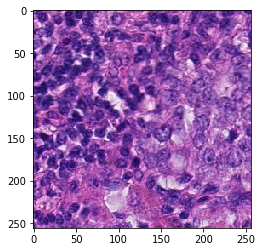

In [0]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.
level= 1
width=slide.level_dimensions[level][0]
height=slide.level_dimensions[level][1]
print('level: %d, width: %d, height: %d' % (level,width,height))
slide_image = read_slide(slide, 
                         x=32000, 
                         y=32000, 
                         level=level, 
                         width=256, 
                         height=256)

#plt.figure(figsize=(10,10))#, dpi=100)
plt.imshow(slide_image)

(256, 256, 3)


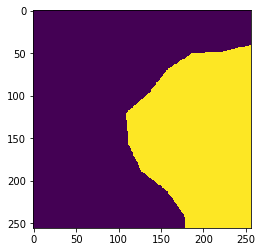

In [0]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=32000, 
                        y=32000, 
                        level=level, 
                        width=256, 
                        height=256)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
print(mask_image.shape)
mask_image = mask_image[:,:,0]

#plt.figure(figsize=(10,10))#, dpi=100)
plt.imshow(mask_image)

In [0]:
mask_image[:,-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

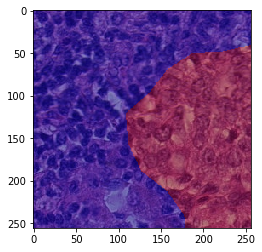

In [0]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
#plt.figure(figsize=(10,10))
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

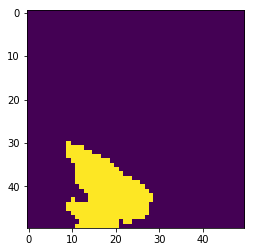

In [0]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

##Note:
This part is about using a sliding window to cut patches and corresponding labels, then save patches that are in tissue areas to local disk and/or upload to google drive

In [0]:
#get google drive folder list
folder_list = drive.ListFile({'q': "trashed=False"}).GetList()
for folder in folder_list:
  print ('folder title: %s, id: %s' % (folder['title'], folder['id']))

folder title: startercode.ipynb, id: 19EtJNMyYX66aNB0G-RokSvPyboRwQr1x
folder title: all_patch, id: 1H4SPQ0-JholuVLHeUKnCnI78aN8AL_N5
folder title: all_label, id: 1R9l_LultkZSd-ll3bSM0tOUy3d541JlE
folder title: all_img, id: 10srpWJyCBkHmINVfudVsFOqCka4hzjR3
folder title: neg_label, id: 1c37M2S5caZsY2pF9VCoDLrqknFBaKnDq
folder title: neg, id: 1uxwlLXrpQjltn9--5_kn6RwlLrpPgV-0
folder title: Model.ipynb, id: 1bZ2V4FTED5lWYheM60u84Z7uqlYHsGEn
folder title: pos_label, id: 1BoEfV1MjNwJSvMKW0LKSuCvrdbPQqICZ
folder title: pos, id: 1r0sU1fNWd3BlpHdfdCs98vKwqJkovAEs
folder title: tmp.jpg, id: 132n5_Xl1poZDTSCziHTFpjGMWhQs7ZJo
folder title: HW5_part3.ipynb, id: 1ep9MIjGoZhjbjV65BnfSFwmfYEcaBpjl
folder title: 091_label_68_71.png, id: 1hQfxHgKDlvzBYD7JXdxGfior3InwhEMo
folder title: 091_67_71.png, id: 17u1Pp7jaBGuewJhw5Mfcg4wAFxpQhxMK
folder title: 091_label_56_71.png, id: 1ND4PVaEuDj5D076v091JZTtojygvTi__
folder title: 091_label_53_71.png, id: 1URqgfWqugPqNCywYCLzcpng450cWRD9z
folder title: 091_lab

In [0]:
#https://stackoverflow.com/questions/26783420/python-how-to-upload-files-to-a-specific-folder-in-google-drive-using-folderid
def upload_to_folder(folder_id, file_name_local, file_name_in_folder):
    file_metadata = {'title': file_name_in_folder, "parents": [{"id": folder_id, "kind": "drive#childList"}]}
    folder = drive.CreateFile(file_metadata)
    folder.SetContentFile(file_name_local) #The contents of the file
    folder.Upload()

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [0]:
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

64417 tissue_pixels pixels (98.3 percent of the image)


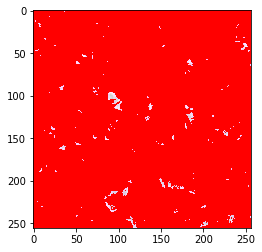

In [0]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
#cut slide from areas where intensity level qualifies(use function above to do so), 
#save positive patch & negative patch respectively to:
#pos patch: /Colab Notebooks/tmp/pos/
#pos label: /Colab Notebooks/tmp/pos_label/
#neg patch: /Colab Notebooks/tmp/neg/
#pos label: /Colab Notebooks/tmp/neg_label/
#need to create corresponding folder in google drive

In [0]:
#folder id in google drive
folder_id_neg_label = '1drNeRJjhFQyRqWkOrmOv8KRJdKYBKQgu'

folder_id_neg = '1SEYxbz6ps0OtxE85O8yHXLJ0YKWY5q6F'

folder_id_pos_label = '1BoEfV1MjNwJSvMKW0LKSuCvrdbPQqICZ'

folder_id_pos = '1r0sU1fNWd3BlpHdfdCs98vKwqJkovAEs'

In [0]:
#-------------------------------------------------------------------
#NOTE: this function is replaced by generate_data_local() below
#but still have some value: how to save item to google drive
#-------------------------------------------------------------------


#set threshold to be 0.03 for judging if the patch is pos or neg.
#i. e. if sum of mask is smaller than pos_label_intensity, then less than 5% of the label has tumor, label it as negative sample
label_threshold = 0.03
neg_counter = pos_counter = 0
#for tumor, mask[i][j]=1
pos_label_intensity = label_threshold * pow(256,2) #np.sum(np.ones([256,256]))
for col in range(patch_size[0]):
  for row in range(patch_size[1]):
    #get patch
    patch = read_slide(slide, 
                       x=col*2*256, 
                       y=row*2*256, 
                       level=1, 
                       width=256, 
                       height=256)    
    #calculate intensity
    tissue_pixels = find_tissue_pixels(patch)
    percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[1]) * 100
    if percent_tissue > 15:
      #save patch & label into google drive
      file_name = slide_index[0]+'_'+str(row)+'_'+str(col)+'.jpg'
      label_name = 'label_'+slide_index[0]+str(row)+'_'+str(col)+'.jpg'
      try:
        #decide if is pos or neg using corresponding mask
        #get mask
        mask_image = read_slide(tumor_mask, 
                       x=col*2*256, 
                       y=row*2*256, 
                       level=1, 
                       width=256, 
                       height=256) 
        mask_image = mask_image[:,:,0]
        #original mask array is read_only, need to make a copy in order to *255
        new_mask=mask_image.copy()
        new_mask*=255
        #save sample & label patch to local disk
        cv2.imwrite(label_name, new_mask)
        cv2.imwrite(file_name, patch)

        #save pos sample
        if np.sum(mask_image) > pos_label_intensity: 
          pos_counter+=1
          print('X: %d, Y: %d, Percent: %.1f, Num_Pos: %d' % (col,row,percent_tissue,pos_counter))
          upload_to_folder(folder_id_pos_label, label_name, label_name)
          upload_to_folder(folder_id_pos, file_name, file_name)
        #save neg sample
        else:
          neg_counter+=1
          print('X: %d, Y: %d, Percent: %.1f, Num_Neg: %d' % (col,row,percent_tissue,neg_counter))
          upload_to_folder(folder_id_neg_label, label_name, label_name)
          upload_to_folder(folder_id_neg, file_name, file_name)
      except Exception as e:
        print(e)

In [0]:
print('Num Pos: %d, Num Neg: %d' % (pos_counter,neg_counter))

In [101]:
! ls

adc.json  all_label  all_patch	neg  neg_label	pos  pos_label	sample_data


In [0]:
#---------------------------------------------------
#same function as above, but only save in LOCAL DISK
#---------------------------------------------------
#set threshold to be 0.03 for judging if the patch is pos or neg.
#i. e. if sum of mask is smaller than pos_label_intensity, then less than 5% of the label has tumor, label it as negative sample
def generate_data_local(slide, tumor_mask, slide_ind, label_threshold = 0.03,percent_tissue_threshold = 15):
  #compute patch size
  patch_size=[slide.level_dimensions[1][0]//256,slide.level_dimensions[1][1]//256]
  print('patch_size:',patch_size)
  #label_threshold = 0.03
  neg_counter = pos_counter = 0
  #for tumor, mask[i][j]=1
  pos_label_intensity = label_threshold * pow(256,2)
  for col in tqdm(range(patch_size[0])):
    for row in range(patch_size[1]):
      #get patch
      patch = read_slide(slide, 
                         x=col*2*256, 
                         y=row*2*256, 
                         level=1, 
                         width=256, 
                         height=256)    
      #calculate intensity
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[1]) * 100
      if percent_tissue > percent_tissue_threshold:
        #save patch & label into google drive
        file_name = slide_index[slide_ind]+'_'+str(row)+'_'+str(col)+'.jpg'
        label_name = 'label_'+slide_index[slide_ind]+'_'+str(row)+'_'+str(col)+'.jpg'
        try:
          #decide if is pos or neg using corresponding mask
          #get mask
          mask_image = read_slide(tumor_mask, 
                         x=col*2*256, 
                         y=row*2*256, 
                         level=1, 
                         width=256, 
                         height=256) 
          mask_image = mask_image[:,:,0]
          #original mask array is read_only, need to make a copy in order to *255
          new_mask=mask_image.copy()
          new_mask*=255
          #save sample & label patch to local disk
          cv2.imwrite(label_name, new_mask)
          cv2.imwrite(file_name, patch)
          
          #save pos sample
          if np.sum(mask_image) > pos_label_intensity: 
            pos_counter+=1
            #print('X: %d, Y: %d, Percent: %.1f, Num_Pos: %d' % (col,row,percent_tissue,pos_counter))
            cv2.imwrite('pos_label/'+label_name, new_mask)
            cv2.imwrite('pos/'+file_name, patch)
            
          #save neg sample
          else:
            neg_counter+=1
            #print('X: %d, Y: %d, Percent: %.1f, Num_Neg: %d' % (col,row,percent_tissue,neg_counter))
            cv2.imwrite('neg_label/'+label_name, new_mask)
            cv2.imwrite('neg/'+file_name, patch)
        except Exception as e:
          print(e)
  return pos_counter,neg_counter

In [0]:
#-----------------------------------------------
#same function as above, but only SAVE IN MEMORY
#-----------------------------------------------
#set threshold to be 0.03 for judging if the patch is pos or neg.
#i. e. if sum of mask is smaller than pos_label_intensity, then less than 5% of the label has tumor, label it as negative sample
def generate_data_memory(slide, tumor_mask, slide_ind, label_threshold = 0.03,percent_tissue_threshold = 15):
  pos_patch, pos_label, neg_patch, neg_label = [],[],[],[]
  #compute patch size
  patch_size=[slide.level_dimensions[1][0]//256,slide.level_dimensions[1][1]//256]
  print('patch_size:',patch_size)
  neg_counter = pos_counter = 0
  #for tumor, mask[i][j]=1
  pos_label_intensity = label_threshold * pow(256,2)
  for col in tqdm(range(patch_size[0])):
    for row in range(patch_size[1]):
      #get patch
      patch = read_slide(slide, 
                         x=col*2*256, 
                         y=row*2*256, 
                         level=1, 
                         width=256, 
                         height=256)    
      #calculate intensity
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[1]) * 100
      if percent_tissue > percent_tissue_threshold:
        #decide if is pos or neg using corresponding mask
        #get mask
        mask_image = read_slide(tumor_mask, 
                       x=col*2*256, 
                       y=row*2*256, 
                       level=1, 
                       width=256, 
                       height=256) 
        mask_image = mask_image[:,:,0]

        #save pos sample
        if np.sum(mask_image) > pos_label_intensity: 
          pos_counter+=1
          pos_patch.append(patch)
          pos_label.append(mask_image)

        #save neg sample
        else:
          neg_counter+=1
          neg_patch.append(patch)
          neg_label.append(mask_image)
  print('Num Pos: %d, Num Neg: %d' % (pos_counter,neg_counter))
  return pos_patch, pos_label, neg_patch, neg_label

In [19]:
slide_paths[-2],slide_index[-2],tumor_mask_paths[-2]

('tumor_110.tif', '110', 'tumor_110_mask.tif')

In [20]:
#! rm pos_label/* neg_label/* pos/* neg/*

rm: cannot remove 'pos_label/*': No such file or directory
rm: cannot remove 'neg_label/*': No such file or directory
rm: cannot remove 'pos/*': No such file or directory
rm: cannot remove 'neg/*': No such file or directory


In [121]:
#This version is for save patch on memory
#add slide index to slide_ind to get patches
slide_ind = [0]
for index in slide_ind: 
  #read slide & mask
  slide_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[index]
  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_paths[index], 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+tumor_mask_paths[index]
  tumor_mask = open_slide(real_path)
  print ("Read tumor mask from %s with width: %d, height: %d" % (tumor_mask_paths[index],
                                                                tumor_mask.level_dimensions[0][0],
                                                                tumor_mask.level_dimensions[0][1]))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(4):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
  print('Getting patches')
  pos_patch, pos_label, neg_patch, neg_label = generate_data_memory(slide, tumor_mask, -2)

  0%|          | 0/120 [00:00<?, ?it/s]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif with width: 61440, height: 53760
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Getting patches
patch_size: [120, 105]


100%|██████████| 120/120 [02:39<00:00,  1.12it/s]

Num Pos: 261, Num Neg: 4276


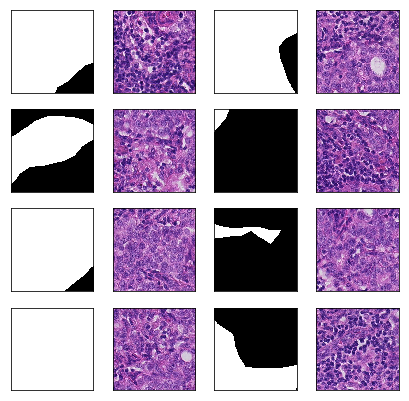

In [122]:
#show some patches & labels
plt.figure(figsize=(7,7))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  if i%2:
    plt.imshow(pos_patch[i], cmap=plt.cm.binary)
  else:
    tmp = pos_label[i] * 255
    plt.imshow(tmp, cmap=plt.cm.binary)

In [123]:
#Balancing data: select 2*(num of pos) data from neg, to reduce imbalancement
#then move selected data to all_patch & all_label

#-----------------------------------------------------------------------------------------
#Note: This is a temporal method, idealy, should only do data augmentation for pos data, 
#then select same amount of data from neg so that neg data is more generalized
#-----------------------------------------------------------------------------------------
neg_patch_down, neg_label_down = [], []
shuffled_index = np.arange(2*len(pos_patch))
np.random.shuffle(shuffled_index)

for i in shuffled_index[:2*len(pos_patch)]:
  neg_patch_down.append(neg_patch[i])
  neg_label_down.append(neg_label[i])
len(neg_patch_down)

522

In [124]:
#add down sampled data to pos, to create test dataset
pos_patch.extend(neg_patch_down)
pos_label.extend(neg_label_down)
#free memory space if needed later 
#del neg_patch, neg_patch_down, neg_label, neg_label_down
#gc.collect()
pos_patch = np.array(pos_patch)
pos_label = np.array(pos_label)
pos_patch.shape,pos_label.shape

((783, 256, 256, 3), (783, 256, 256))

In [125]:
pos_label = pos_label.reshape([pos_patch.shape[0],256,256,1])
pos_label.shape

(783, 256, 256, 1)

In [0]:
#--------------------------------------------------
#no need to run this if only run as temporal
#save item in all_patch & all_label to google drive
def save_folder_to_gdrive(path, folder_id, header):  
  for item in tqdm(path):
    try:
      upload_to_folder(folder_id, header+item, item)
    except Exception as exc:
      print(exc, item)    

In [0]:
#get folder id from folder list acquired above
folder_id_all_patch = '1H4SPQ0-JholuVLHeUKnCnI78aN8AL_N5'
folder_id_all_label = '1R9l_LultkZSd-ll3bSM0tOUy3d541JlE'

In [0]:
save_folder_to_gdrive(all_patch_dir, folder_id_all_patch, 'all_patch/')

 84%|████████▍ | 658/783 [17:16<02:31,  1.21s/it]

<HttpError 502 when requesting https://www.googleapis.com/upload/drive/v2/files?alt=json&uploadType=resumable returned "Bad Gateway">


100%|██████████| 783/783 [20:19<00:00,  1.34s/it]


In [0]:
save_folder_to_gdrive(all_label_dir, folder_id_all_label, 'all_label/')
#--------------------------------------------------

100%|██████████| 783/783 [19:16<00:00,  1.59s/it]


##Note:
This part is about the U-net model, img_data_generator

In [0]:
#preprocessing: normalization
pos_patch = pos_patch / 255.0

In [128]:
#-------------------------------------------------------------------------------
#NOTE: incremental approach, now only train on 091.tif, later train on more data
#-------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(pos_patch, pos_label, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((548, 256, 256, 3),
 (235, 256, 256, 3),
 (548, 256, 256, 1),
 (235, 256, 256, 1))

In [129]:
#define model
inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [130]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_97[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_98[0][0]                  
__________________________________________________________________________________________________
conv2d_99 

In [0]:
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [132]:
history=model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size = 16, epochs=5)

Train on 548 samples, validate on 235 samples
Epoch 1/5
548/548 [==============================] - 89s 162ms/step - loss: 0.7122 - acc: 0.7485 - val_loss: 0.2940 - val_acc: 0.8103
Epoch 2/5
548/548 [==============================] - 78s 142ms/step - loss: 0.3069 - acc: 0.8239 - val_loss: 0.2154 - val_acc: 0.8797
Epoch 3/5
548/548 [==============================] - 77s 141ms/step - loss: 0.6699 - acc: 0.5215 - val_loss: 0.6854 - val_acc: 0.8103
Epoch 4/5
548/548 [==============================] - 77s 141ms/step - loss: 0.6820 - acc: 0.7485 - val_loss: 0.6726 - val_acc: 0.8103
Epoch 5/5
548/548 [==============================] - 77s 141ms/step - loss: 0.6725 - acc: 0.7485 - val_loss: 0.6615 - val_acc: 0.8103


In [133]:
tmp = X_test[0].reshape([1,256,256,3])
res = model.predict(tmp)
res.shape

(1, 256, 256, 1)

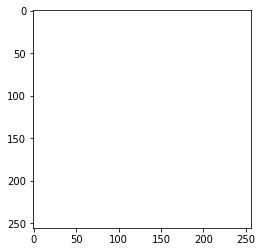

In [134]:
res = res.reshape([256,256])
#res = res * 255
plt.imshow(res, cmap=plt.cm.binary)

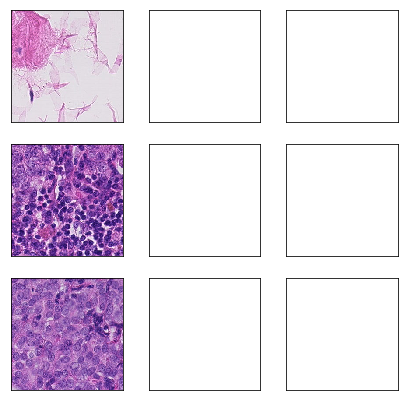

In [141]:
#show some patches & labels
plt.figure(figsize=(7,7))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  if i%3 == 2:
    tmp = X_test[i//3+30].reshape([1,256,256,3])
    res = model.predict(tmp)
    res = res.reshape([256,256])
    plt.imshow(res, cmap=plt.cm.binary)    
  if i%3 == 1:  
    tmp = y_test[i//3+30]
    tmp = tmp.reshape([256,256])
    plt.imshow(tmp, cmap=plt.cm.binary)
  if not i%3:
    plt.imshow(X_test[i//3+20], cmap=plt.cm.binary)